This notebook demos some common plotting and analysis we do for HSI NeRFs.
If you have trained the hsi_mipnerf_MD_GR model from the README, then this code should work.

In [1]:
import os
from tqdm import tqdm
import numpy as np
import tifffile
import json

import matplotlib.pyplot as plt

import spectral.io.envi as envi
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 14})

Reading in all images

In [2]:
data_root = '../data/complex_facility/Images'
n_files = 231
all_imgs = []
all_pixels = []
for img_i in tqdm(range(n_files)):
    img = envi.open(os.path.join(data_root, f"MakoSpectrometer-t{img_i:04d}.img.hdr"))
    img = 1e6 * np.asarray(img.asarray())
    all_imgs.append(img)
    all_pixels.append(img.reshape((-1, 128)))

pixels = np.asarray(all_pixels).reshape((-1, 128))
stdizer = StandardScaler().fit(pixels)

100%|██████████| 231/231 [00:01<00:00, 127.36it/s]


This function makes plotting falsecoloring easy.
If plotting full radiance in microflicks HSI (the output and ground truth), then use scale=1e-6

In [3]:
def make_img_plottable(tmp_img, pca = None, max = 0.0019809045970402978, min = 0.00017077310969582421, channels=[59, 7, 15], scale=1):
    # tmp_img =  (tmp_img - 0.00017077310969582421) / (0.0019809045970402978 - 0.00017077310969582421)
    tmp_img = tmp_img.copy()
    if pca:
        og_shape = tmp_img.shape
        tmp_img = tmp_img.reshape((-1, 128))
        tmp_img = pca.transform(tmp_img)
        tmp_img = tmp_img.reshape(((128, 128, 3)))
        tmp_img = (tmp_img - min) / (max - min)
    else:
        tmp_img *= scale
        if max is None or min is None:
            tmp_img = ((tmp_img - tmp_img.min()) / (tmp_img.max() - tmp_img.min()))[:, :, channels]
        else:
            tmp_img = ((tmp_img - min) / (max - min))[:, :, channels]
    return tmp_img

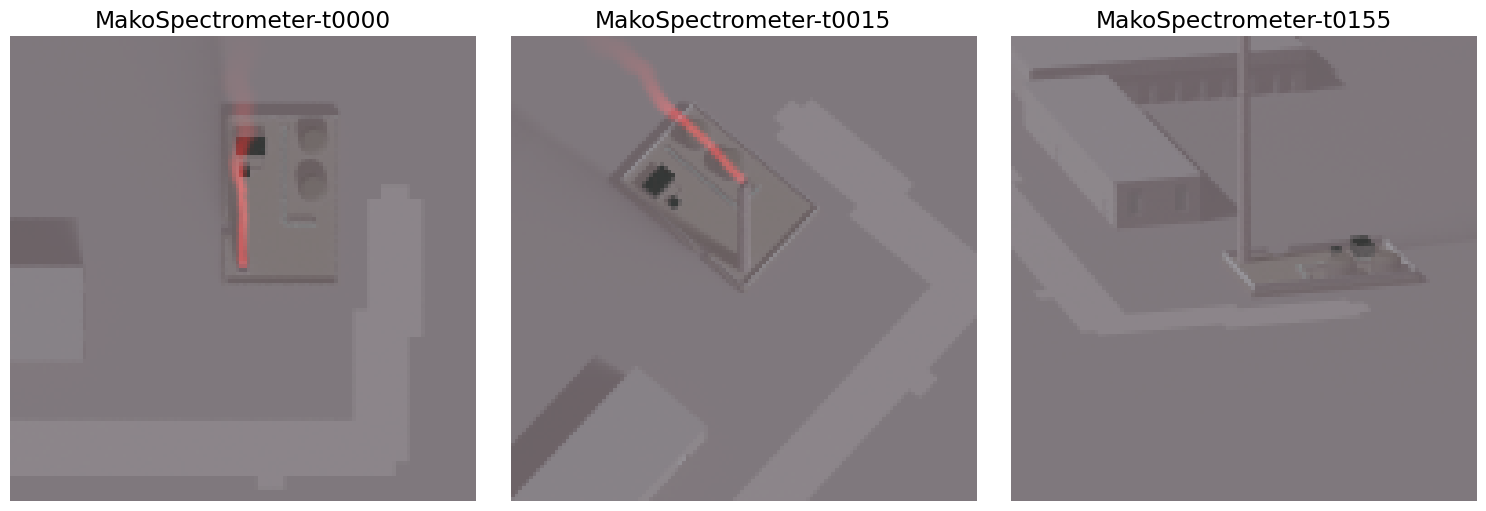

In [4]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)
fig.set_size_inches(15, 5)

i = 0
axs[0].imshow(make_img_plottable(all_imgs[i], scale=1e-6))
axs[0].set_axis_off()
axs[0].set_title(f"MakoSpectrometer-t{i:04d}")

i = 15
axs[1].imshow(make_img_plottable(all_imgs[i], scale=1e-6))
axs[1].set_axis_off()
axs[1].set_title(f"MakoSpectrometer-t{i:04d}")

i = 155
axs[2].imshow(make_img_plottable(all_imgs[i], scale=1e-6))
axs[2].set_axis_off()
axs[2].set_title(f"MakoSpectrometer-t{i:04d}")

plt.savefig("False_Color_Examples.jpg")

Example of what is contained in the associated truth files

In [5]:
img_i = 100
gt = envi.open(os.path.join(data_root, f"truth-t{img_i:04d}.img.hdr"))
gt.metadata

{'description': "Truth data generated by DIRSIG 2024.23 (1930509) 'BasicPlatform' plugin",
 'samples': '128',
 'lines': '128',
 'bands': '10',
 'header offset': '0',
 'data type': '5',
 'interleave': 'BIP',
 'byte order': '0',
 'band names': ['Scene ENU X Coordinate [m]',
  'Scene ENU Y Coordinate [m]',
  'Scene ENU Z Coordinate [m]',
  'Distance [m]',
  'View Angle Cosine',
  'Texture U Coordinate',
  'Texture V Coordinate',
  'Path Transmission',
  'Path Radiance',
  'Temperature [K]']}

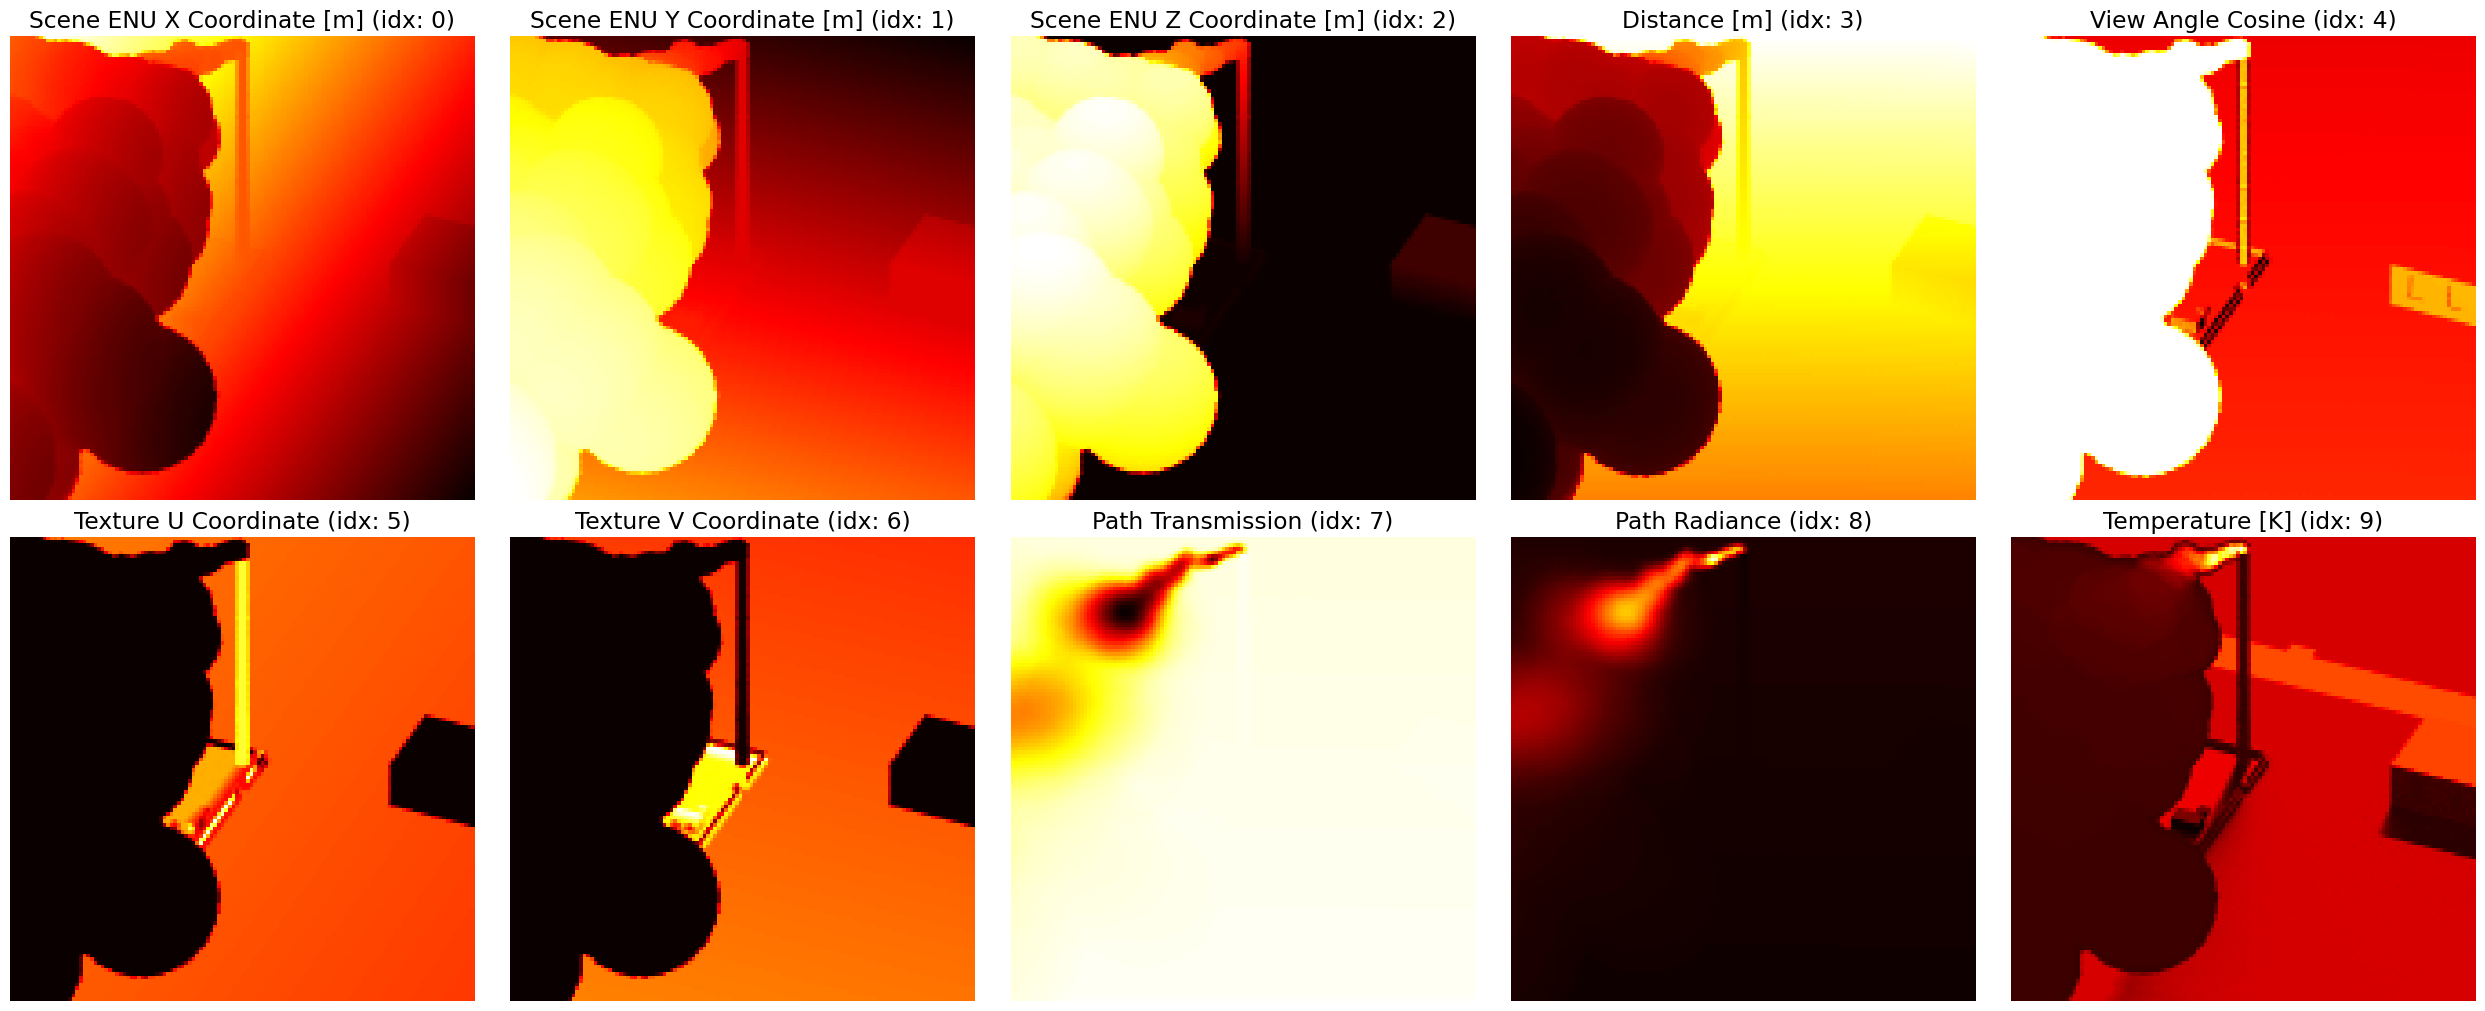

In [6]:
fig, axs = plt.subplots(2, 5, constrained_layout=True)
fig.set_size_inches(25, 10)
axs = axs.flatten()

for i in range(len(gt.metadata['band names'])):
    axs[i].imshow(gt[:, :, i], cmap='hot')
    axs[i].set_title(f"{gt.metadata['band names'][i]} (idx: {i})")
    axs[i].set_axis_off()

plt.savefig("Ground_Truth_Example.jpg")

This just creates the wavelengths that each channel the images produces (from the MAKO sensor)

In [7]:
x_new = np.linspace(7.8, 7.8 + 0.044 * 127, 128)
print(x_new[[59, 7, 15]])
print(x_new[0], x_new[-1])

[10.396  8.108  8.46 ]
7.8 13.388


Here are some example plots and analysis stuff.
Here we start with some ACE detection examples

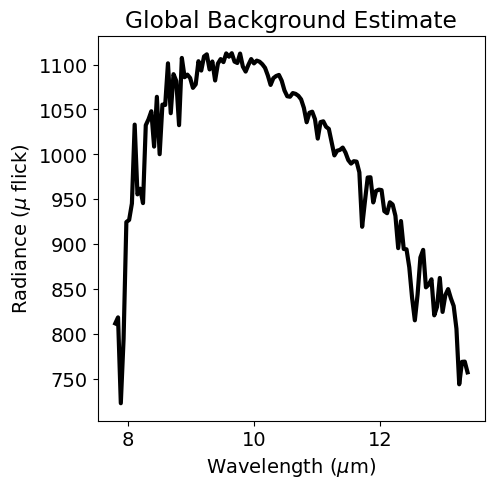

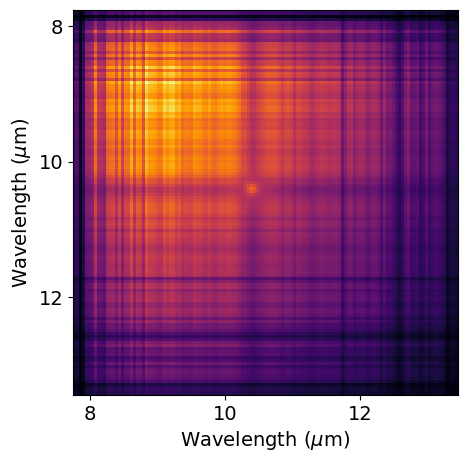

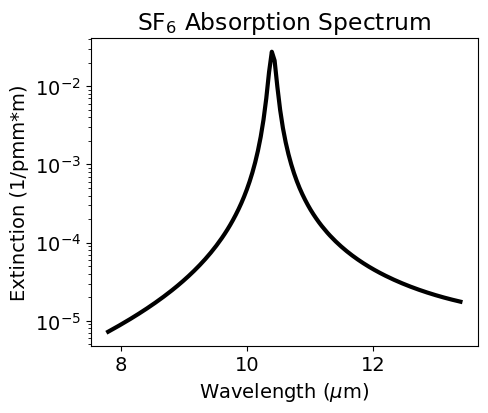

In [8]:
tmp_pixels = all_imgs[0].reshape((-1, 128))
mean = np.mean(tmp_pixels, 0)

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

axs.plot(x_new, mean, c='k', linewidth=3)
axs.set_ylabel("Radiance ($\mu$ flick)")
axs.set_xlabel("Wavelength ($\mu$m)")
axs.set_title("Global Background Estimate")

plt.show()

cov = np.cov(tmp_pixels.T)

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

im = axs.imshow(cov, cmap='inferno')

# Choose wavelengths to label
label_wavelengths = [8, 10, 12]
label_indices = [np.argmin(np.abs(x_new - lw)) for lw in label_wavelengths]
label_strings = [f"{x_new[i]:.0f}" for i in label_indices]

# Apply tick positions and labels
axs.set_xticks(label_indices)
axs.set_xticklabels(label_strings)
axs.set_yticks(label_indices)
axs.set_yticklabels(label_strings)

axs.set_xlabel("Wavelength ($\mu$m)")
axs.set_ylabel("Wavelength ($\mu$m)")

plt.show()




gas_path = "../data/sf6_ext.txt"
data = np.loadtxt(gas_path, delimiter="\t")
wavelengths = 10000 / data[:, 0]
absorption = data[:, 1]
# Interpolate to 128 points
x_new = np.linspace(7.8, 7.8 + 0.044 * 127, 128)
targ_sig = np.interp(x_new, wavelengths, absorption)

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(5, 4)


plt.plot(x_new, targ_sig, c='k', linewidth=3)
plt.yscale("log")
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("Extinction (1/pmm*m)")
plt.title("SF$_6$ Absorption Spectrum")

plt.show()

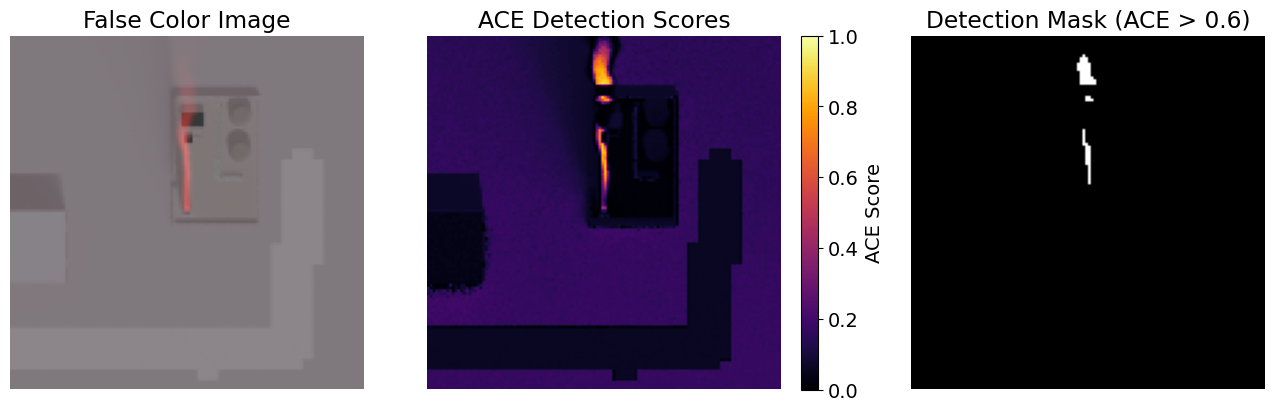

In [9]:
def ACE_det(img, gt, mean=None, cov=None, regularize_eps=1e-6):
    """
    Compute ACE detection score map.

    Args:
        img: torch.Tensor of shape [H, W, B] — expected in flicks
        gt: numpy array of shape [B,] — target signature (also in flicks)
        mean: optional precomputed background mean (in flicks)
        cov: optional precomputed covariance (in flicks)
        regularize_eps: epsilon for numerical stability
    """
    img_tmp = img.copy()
    H, W, B = img_tmp.shape

    # === Convert to numpy
    pixels = img_tmp.reshape(-1, B).astype(np.float32)

    # === Heuristic: detect if values are in microflicks
    max_val = np.percentile(pixels, 99)
    if max_val > 100:  # threshold for microflicks (very conservative)
        pixels = pixels / 1e6
        if mean is not None:
            mean = mean / 1e6
        if cov is not None:
            cov = cov / (1e6 ** 2)

    # === Center the pixels
    if mean is None:
        mean = pixels.mean(axis=0)
    pixels -= mean

    # === Covariance and inverse
    if cov is None:
        cov = np.cov(pixels.T)
    cov += regularize_eps * np.eye(cov.shape[0])
    C_hat = np.linalg.inv(cov)

    # === ACE computation
    num = gt.T @ C_hat @ pixels.T                     # shape: (N,)
    den1 = gt.T @ C_hat @ gt                          # scalar
    den2 = np.sum((pixels @ C_hat) * pixels, axis=1)  # shape: (N,)
    ace = (num ** 2) / (den1 * den2 + 1e-12)

    return ace.reshape(H, W)



gas_path = "../data/sf6_ext.txt"
data = np.loadtxt(gas_path, delimiter="\t")
wavelengths = 10000 / data[:, 0]
absorption = data[:, 1]
# Interpolate to 128 points
x_new = np.linspace(7.8, 7.8 + 0.044 * 127, 128)
targ_sig = np.interp(x_new, wavelengths, absorption)






fig, axs = plt.subplots(1, 3, constrained_layout=True)
fig.set_size_inches(13, 4)

img = all_imgs[0].copy()

# Plot 1: False color
axs[0].imshow(make_img_plottable(img, scale=1e-6))
axs[0].set_axis_off()
axs[0].set_title("False Color Image")

# Plot 2: ACE Detection
ace = ACE_det(img, targ_sig)
im2 = axs[1].imshow(ace, vmin=0, vmax=1, cmap='inferno')
axs[1].set_axis_off()
axs[1].set_title("ACE Detection Scores")

# Add colorbar linked to ACE image
cbar = fig.colorbar(im2, ax=axs[1])
cbar.set_label("ACE Score")

# Plot 3: Pseudo mask
axs[2].imshow(ace > 0.6, cmap='gray')
axs[2].set_axis_off()
axs[2].set_title("Detection Mask (ACE > 0.6)")

plt.show()

Here are some example of the testing and rendered versions of the image (need to have run the readme example)

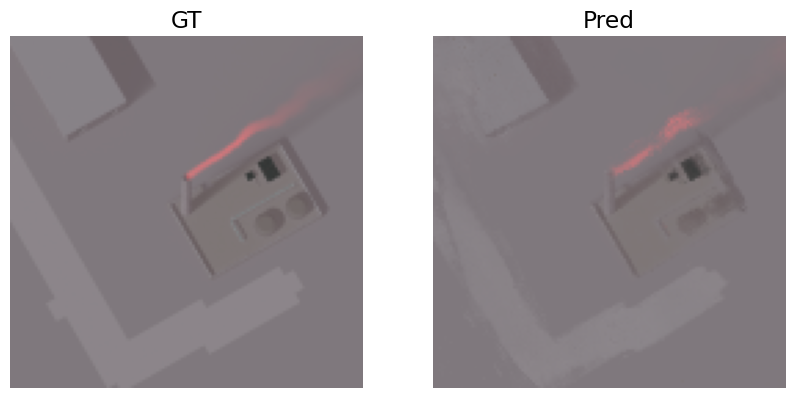

This image's performance:
PSNR: 40.485
SSIM: 0.955
AUC: 0.974
TPR: 0.878

Average model performance:
PSNR: 37.881
SSIM: 0.910
AUC: 0.784
TPR: 0.451


In [10]:
model_path = "../outputs/complex_facility/hsi_mipnerf_MD_GR/readme_test"
img_idx = 6
gt = all_imgs[img_idx]
img_25 = tifffile.imread(os.path.join(model_path, "hsi-eval", "best", f"eval_img_t{img_idx:04d}.tif"))

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].imshow(make_img_plottable(gt, scale=1e-6))
axs[0].set_axis_off()
axs[1].imshow(make_img_plottable(img_25, scale=1e-6))
axs[1].set_axis_off()

axs[0].set_title("GT")
axs[1].set_title("Pred")

plt.show()


print("This image's performance:")

results_path = os.path.join(model_path, "hsi-eval", "best", "per_image_eval_metrics.json")
with open(results_path) as handle:
    res = json.load(handle)

metrics = ["psnr", "ssim", "auc", "tpr"]
for i in range(len(metrics)):
    print(f"{metrics[i].upper()}: {res[str(img_idx)][metrics[i]]:.3f}")



print("\nAverage model performance:")

results_path = os.path.join(model_path, "hsi-eval", "best", "metrics.json")
with open(results_path) as handle:
    res = json.load(handle)

metrics = ["psnr", "ssim", "auc", "tpr"]
for i in range(len(metrics)):
    print(f"{metrics[i].upper()}: {res['results'][metrics[i]]:.3f}")



